In [1]:
import argparse
import os
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import skimage
import tifffile
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook

from segmentation_utils import *

In [2]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [3]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [4]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0037_T1-Z-0.5"
    well_fov = "F4-3"
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


window_size = 2
input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


In [5]:
if in_notebook:
    return_dict = read_in_channels(
        find_files_available(input_dir),
        channel_dict={
            "nuclei": "405",
            "cyto1": "488",
            "cyto2": "555",
            "cyto3": "640",
            "brightfield": "TRANS",
        },
        channels_to_read=["cyto1"],
    )
    cyto1_raw = return_dict["cyto1"]
    del cyto1_raw
cell_mask_path = pathlib.Path(f"{mask_path}/cell_mask.tiff")
cell_mask = read_zstack_image(cell_mask_path)

In [6]:
# convert the cell masks to binary masks
cell_binary_mask = cell_mask.copy()
cell_binary_mask[cell_binary_mask > 0] = 1
# dilate the cell masks slightly
cell_binary_mask = skimage.morphology.binary_dilation(
    cell_binary_mask, skimage.morphology.ball(10)
)
# convert back to instance mask
# make sure each instance has a unique integer label
organoid_masks = skimage.measure.label(cell_binary_mask)

In [7]:
# save the organoid masks
organoid_mask_output_path = pathlib.Path(f"{mask_path}/organoid_mask.tiff").resolve()
tifffile.imwrite(organoid_mask_output_path, organoid_masks.astype(np.uint16))

In [8]:
end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
end_time = time.time()
print(f"""
    Memory and time profiling for the run:\n
    Memory usage: {end_mem - start_mem:.2f} MB\n
    Time:\n
    --- %s seconds --- % {(end_time - start_time)}\n
    --- %s minutes --- % {((end_time - start_time) / 60)}\n
    --- %s hours --- % {((end_time - start_time) / 3600)}
""")


    Memory and time profiling for the run:

    Memory usage: 4008.52 MB

    Time:

    --- %s seconds --- % 508.2739622592926

    --- %s minutes --- % 8.471232704321544

    --- %s hours --- % 0.1411872117386924



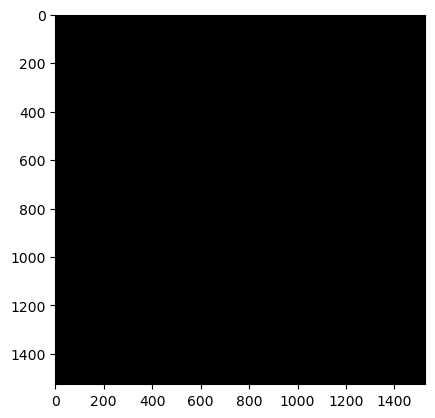

In [9]:
if in_notebook:
    plt.imshow(organoid_masks[organoid_masks.shape[0] // 2], cmap="nipy_spectral")